**Diffusion-reaction equation**

Retyped by Theodoret Putra Agatho on 5 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/diffusion.reaction.html)

In [1]:
pip install deepxde

**Problem setup**

We will solve the following 1D diffusion-reaction equation:

\begin{align}
        \frac{\partial y}{\partial t} = d \frac{\partial ^2 y}{\partial x^2} + e^{-t} (3 \frac{\text{sin } 2x}{2} + \frac{8 \text{ sin } 3x}{3} + \frac{15 \text{ sin } 4x}{4} + \frac{63 \text{ sin } 8x}{8})
    \end{align}

with the initial condition

\begin{align}
        y(t, -\pi) = \text{sin } + \frac{\text{sin } 2x}{2} + \frac{\text{sin } 3x}{3} + \frac{\text{sin } 4x}{4} + \frac{\text{sin } 8x}{8}, x \in [-\p, \pi]
    \end{align}

and the Dirichlet boundary condition

\begin{align}
        y(t, -\pi) = y(t, \pi) = 0, t \in [0,1]
    \end{align}

We also specifiy the following parameters for the equation:

\begin{align}
        d = 1
    \end{align}

The exact solution is

\begin{align}
        y(x, t) = e^{-t} (\text{sin } x + \frac{\text{sin } 2x}{2} + \frac{\text{sin }3x}{3} + \frac{\text{sin } 4x}{4} + \frac{\text{sin } 8x}{8})
    \end{align}

**Implementation**

This decription goes through the implementation of a solver for the above described diffusion-reaction equation step-by-step.

First, DeepXDE, Numpy, and TensorFlow libraries are imported:

In [2]:
import deepxde as dde
import numpy as np
import tensorflow as tf
# import pytorch as torch

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term



Next, we express the PDE residual of the diffusion-reaction equation:

In [3]:
def pde(x, y):
  dy_t = dde.grad.jacobian(y, x, i=0, j=1)
  dy_xx = dde.grad.hessian(y, x, i=0, j=0)
  d = 1
  # Backend tensorflow.compact.v1 or tensorflow
  return (
      dy_t
      - d * dy_xx
      - tf.exp(-x[:, 1:])
      * (
          3 * tf.sin(2 * x[:, 0:1]) / 2
          + 8 * tf.sin(3 * x[:, 0:1]) / 3
          + 15 * tf.sin(4 * x[:, 0:1]) / 4
          + 63 * tf.sin(8 * x[:, 0:1]) / 8
      )
  )
  # # Backend pytorch
  # return (
  #     dy_t
  #     - d * dy_xx
  #     - torch.exp(-x[:, 1:])
  #     * (
  #         3 * torch.sin(2 * x[:, 0:1]) / 2
  #         + 8 * torch.sin(3 * x[:, 0:1]) / 3
  #         + 15 * torch.sin(4 * x[:, 0:1]) / 4
  #         + 63 * torch.sin(8 * x[:, 0:1]) / 8
  #     )
  # )

The first argument to `pde` is the 2 dimensional vector where the first component(`x[:, 0]`) is the $x$-coordinate, and the second component(`x[:, 1]`) is the $t$-coordinate. The second argument is the network output, i.e., the solution $u(x)$, but here we use `y` as the name of the variable.

Then we define the solution to the PDE:

In [4]:
def func(x):
  return np.exp(-x[:, 1:]) * (
      np.sin(x[:, 0:1])
      + np.sin(2 * x[:, 0:1]) / 2
      + np.sin(3 * x[:, 0:1]) / 3
      + np.sin(4 * x[:, 0:1]) / 4
      + np.sin(8 * x[:, 0:1]) / 8
  )

Now we can define a computational geometry and time domain. We can use a built-in class `Interval` and `TimeDomain` and we combine both the domains using `GeometryXTime` as follows

In [5]:
# geom = dde.geometry.Interval(-1, 1)
geom = dde.geometry.Interval(-np.pi, np.pi)
timedomain = dde.geometry.TimeDomain(0, 0.99)
# timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Now, we have specified the geometry and the PDE residual. We then define the `TimePDE` problem as

In [6]:
data = dde.data.TimePDE(
    geomtime, pde, [], num_domain=320, solution=func, num_test=80000
)

The number 320 is the number of training residual points sampled inside the domain, and the number 80000 is the number of pointas sampled inside the domain for testing the PDE loss.

Next, we choose the network. Here, we use a fully connected neural network of depth 7 (i.e., hidden layers) and width 30:

In [7]:
layer_size = [2] + [30] * 6 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

The we construct a function that satisfies both the initial and the boundary conditions to transform the network output. In this case, $t(\pi ^2 - x^2)y + \text{sin } x + \frac{\text{sin } 2x}{2} + \frac{\text{sin }3x}{3} + \frac{\text{sin }4x}{4} + \frac{\text{sin }8x}{8}$ is used. if $t$ is equal to 0, the initial condition is recovered. When $x$ is equal to $-\pi$ or $\pi$, the boundary condition is recovered. Hence the initial and boundary conditions are both hard conditions.

In [8]:
def output_transform(x, y):
  return (
      x[:, 1:2] * (np.pi ** 2 - x[:, 0:1] ** 2) * y
      + tf.sin(x[:, 0:1])
      + tf.sin(2 * x[:, 0:1]) / 2
      + tf.sin(3 * x[:, 0:1]) / 3
      + tf.sin(4 * x[:, 0:1]) / 4
      + tf.sin(8 * x[:, 0:1]) / 8
  )
  # # Backend pytorch
  # return (
  #     x[:, 1:2] * (np.pi ** 2 - x[:, 0:1] ** 2) * y
  #     + torch.sin(x[:, 0:1])
  #     + torch.sin(2 * x[:, 0:1]) / 2
  #     + torch.sin(3 * x[:, 0:1]) / 3
  #     + torch.sin(4 * x[:, 0:1]) / 4
  #     + torch.sin(8 * x[:, 0:1]) / 8
  # )

net.apply_output_transform(output_transform)

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate. We then train the model for 20000 iterations.

In [9]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

Compiling model...
Building feed-forward neural network...


/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 1.108580 s

'compile' took 3.182398 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [9.82e+00]    [1.01e+01]    [9.38e-01]    
1000      [1.23e-01]    [1.21e-01]    [3.21e-02]    
2000      [1.04e-02]    [1.08e-02]    [5.19e-03]    
3000      [6.29e-03]    [6.49e-03]    [1.49e-02]    
4000      [4.17e-02]    [4.24e-02]    [3.01e-02]    
5000      [3.35e-03]    [3.64e-03]    [1.35e-02]    
6000      [1.80e-03]    [1.99e-03]    [8.47e-03]    
7000      [5.09e-03]    [5.20e-03]    [6.08e-03]    
8000      [1.45e-03]    [1.58e-03]    [1.45e-02]    
9000      [8.25e-03]    [8.50e-03]    [9.94e-03]    
10000     [2.37e-03]    [2.52e-03]    [1.49e-02]    
11000     [1.89e-03]    [1.96e-03]    [1.25e-02]    
12000     [9.80e-04]    [1.07e-03]    [4.40e-03]    
13000     [1.29e-03]    [1.36e-03]    [7.35e-03]    
14000     [4.27e-03]    [4.46e-03]    [9.86e-03]    
15000     [1.37e-03]    [1.41e-03]    [3.86e-03]    
16000     [2.76e-03]    [2.8

We also save and plot the best trained result and loss history

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


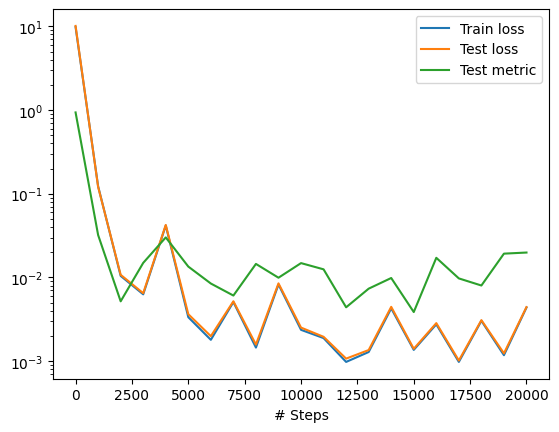

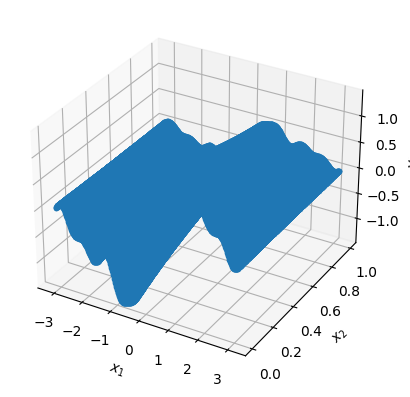

In [10]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)